# Modifiable areal unit problem (MAUP)

The Modifiable Areal Unit Problem (MAUP) is a well-known issue in spatial analysis and geography that arises when aggregating data into different geographic units or scales. It refers to the fact that the results of statistical analyses can vary significantly depending on how the geographic units (e.g., census tracts, zip codes, counties) are defined or delineated.

This notebook provides an example of MAUP problem from human sentiments of heat exposure from social media Twitter data in the city of Chicago.

## Notebook Outline
- [Processing Twitter/X Data](#processing)
- [Understanding How Human Sentiments of Heat Exposure from Tweet Posts](#understand)
- [Geographic Unit](#unit)
    - [Census Tract](#census)
    - [1km Spatial Resolution](#1km)

In [1]:
## Import Library
import pytz
from datetime import datetime, timedelta
import os
import geopandas as gpd
import json
from shapely.geometry import Polygon, Point, MultiPolygon
import shapefile
import re
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
import numpy as np
import random
import csv

<a id='processing'></a>

## 1. Processing Twitter/X Data

The following cell will allow users to extract and filter the social media data Twitter/X.

In [2]:
## Load chicago shapefile
shapefile = gpd.read_file("./geo/geo_export_5bb8636f-65b7-450a-8fd9-7f01027fd84b.shp")
chicago_shape = shapefile["geometry"][0]

Filter all the Twitter/X data by location, find all data within the city of Chicago

In [3]:
## get the twitter in chicago
## City scale analysis
## This block of code will takes a long time
## We iterate through all the twitter collected for find twitter in chicago
## Get the filename
filelist = os.listdir('./data/')
filelist

twitter_in_chicago = []

# Opening JSON file
for filename in filelist:
    filepath = "./data/"+filename
    print(filepath)
    f = open(filepath)
    data = json.load(f)
    
    ## Read the data if the centroid of the twitter point polygon lies within the boundary of the city of Chicago
    for i in range(0, len(data)):
        try:
            ##Need to deal with case when the shapefile is too big
            text = data[i]["text"]
            t = data[i]['created_at']
            ## Case 1
            ## Twitter with exact geospatial location
            if (data[i]['geo']!=None):
                lat = data[i]['geo']['coordinates'][0]
                lon = data[i]['geo']['coordinates'][1]
                exact_loc = Point(lon, lat)
                if chicago_shape.contains(exact_loc):
                    ## print("inside")
                    twitter_in_chicago.append((exact_loc, t, text))
            else:
                ## Twitter with a polygon bounding box
                poly = data[i]['place']['bounding_box']["coordinates"][0]
                lon = -1000
                lat = -1000

                lon = [p[0] for p in poly]
                lat = [p[1] for p in poly]
                centroid = (sum(lon) / len(poly), sum(lat) / len(poly))
                point = Point(centroid)
                ## check if a centroid is in the bounding box of chicago
                if chicago_shape.contains(point):
                    ## print("inside")
                    twitter_in_chicago.append((poly, t, text))
        except:
            ## no geographical location
            pass
    # Closing file
    f.close()

./data/250000-tweets-2021-09-25_04-59-49.json
./data/250000-tweets-2021-09-26_01-46-49.json
./data/250000-tweets-2021-09-25_20-12-57.json
./data/250000-tweets-2021-09-26_19-43-23.json
./data/250000-tweets-2021-09-26_22-13-26.json
./data/250000-tweets-2021-09-25_17-48-51.json
./data/250000-tweets-2021-09-26_09-39-36.json
./data/250000-tweets-2021-09-26_07-36-30.json
./data/250000-tweets-2021-09-25_22-39-35.json
./data/250000-tweets-2021-09-25_13-24-18.json
./data/250000-tweets-2021-09-25_01-48-23.json
./data/250000-tweets-2021-09-26_11-29-11.json
./data/250000-tweets-2021-09-26_13-18-44.json
./data/250000-tweets-2021-09-25_09-29-48.json
./data/250000-tweets-2021-09-26_17-16-06.json
./data/250000-tweets-2021-09-26_15-10-52.json
./data/250000-tweets-2021-09-25_11-25-23.json
./data/250000-tweets-2021-09-25_07-33-30.json
./data/250000-tweets-2021-09-25_15-34-24.json
./data/250000-tweets-2021-09-26_04-56-08.json


<a id='understand'></a>

## 2. Understanding How Human Sentiments of Heat Exposure from Tweet Posts

The following cell will allow users to apply heat dictionary generated using pretrained NLP model to understand the Twitter post

A keyword-based NLP mehtod is adopted to the generated the heat dictionary. And the heat dictionary is used to access whether each Tweet post is talking about weather and how much is it talking about hot/cold weather.

In [6]:
## Read the word heat dictionary
f = open('./geo/data20000.txt','r')
content = f.read()
f.close()
dict_word = {}
content_list = content.split(",")
for i in range(0,len(content_list)):
    try:
        word = content_list[i].split(":")[0].split("'")[1]
        #print(content_list[i].split(":"))
        val = float(content_list[i].split(":")[1])
        dict_word[word] = val
    except:
        pass

Apply the heat dictionary onto all the Tweets found in the city of Chicago.

In [7]:
## Iterate through all twitter data in chicago

d_twitter = []
for i in range(0, len(twitter_in_chicago)):
    loc = twitter_in_chicago[i][0]
    t = twitter_in_chicago[i][1]
    text = twitter_in_chicago[i][2]
    res = re.findall(r'\w+', text.lower())
    val = 0
    for word in res:
        if word in dict_word.keys():
            val = val + dict_word[word]
    ## remove weather-irrelevant twitter
    ## if none of the word in the heat dictionary show up 
    if (val!=0):
        d_twitter.append((loc, t, val))

In [8]:
print("There are "+str(len(d_twitter))+" weather-related Twitter in Chicago")

There are 869 weather-related Twitter in Chicago


<a id='unit'></a>

## 3. Geographic Unit

<a id='census'></a>

## 3.1. Census Tract

The following cell will allow users to aggregate the human sentiments of heat exposure from each Tweets to the spaital domain in the city of Chicago.

Aggregate the result into census tract. [Inverse Distance Weighting (IDW)](https://en.wikipedia.org/wiki/Inverse_distance_weighting) is used when a census tract value is missinng.

In [12]:
## Integrate into census tract level
chicago = gpd.read_file("./Census_tract/geo_export_dc0b9c70-c036-4bcc-a602-8e9b9d36ea9f.shp")

In [13]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."
...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932..."
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930..."
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982..."
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855..."


In [14]:
## Generate a random point from a polygon
import random

def generate_random(number, polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [15]:
## Function to generate random location twitter
## For monte caro experiment
## Enable exact and poly if you want to see how many twitter has exact location and how many comes with a polygon
#exact = 0
#poly = 0
def generate_random_loc(weather_related_twitter):
    random_loc_twitter = []
    for ele in weather_related_twitter:
        loc = ele[0]
        point = 0
        #print(loc)
        if (type(loc)==Point):
            ## exact location extracted
            point = loc
            #exact = exact+1
        else:
            ## Select a random point from a multi-polygon
            point = generate_random(1, Polygon(loc))
            #poly = poly+1
        random_loc_twitter.append([point, ele[2]])
    return random_loc_twitter

In [16]:
d_final_census_track = {}

for i in range(0, 10):
    ## try 10 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for index, row in chicago.iterrows():
        key = index
        ele = row['geometry'] 
        lon = ele.centroid.x
        lat = ele.centroid.y
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down

        if (key not in d_final_census_track.keys()):
            d_final_census_track[index]=[rt]
        else:
            d_final_census_track[index].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9


Calculate Normalized Human Sentiments of Heat Exposure

In [17]:
heat_exposure_map_census_track = {}
for key in d_final_census_track.keys():
    ## Get the average hot exposure
    heat_exposure_map_census_track[key] = np.mean(d_final_census_track[key])

In [18]:
## nomalization to 0-1
mn = min(heat_exposure_map_census_track.values())
mx = max(heat_exposure_map_census_track.values())
for key in heat_exposure_map_census_track.keys():
    norm = (heat_exposure_map_census_track[key]-mn)/(mx-mn)
    heat_exposure_map_census_track[key] = norm

In [19]:
chicago["he_val"]=list(heat_exposure_map_census_track.values())

Show the result geopandas dataframe for visualization

In [20]:
chicago

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,he_val
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",0.616735
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",0.556374
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",0.610112
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",0.588897
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",0.709283
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,None,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",0.579146
797,7,7.0,031,17031070500,705,Census Tract 705,None,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",0.605453
798,13,13.0,031,17031130300,1303,Census Tract 1303,None,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",0.579452
799,29,29.0,031,17031292200,2922,Census Tract 2922,None,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",0.540745


The following cell conduct a census tract level and 1km spatial unit analysis of human sentiments of urban heat in the city of Chicago to investigate the difference in pattern between these two

<Axes: >

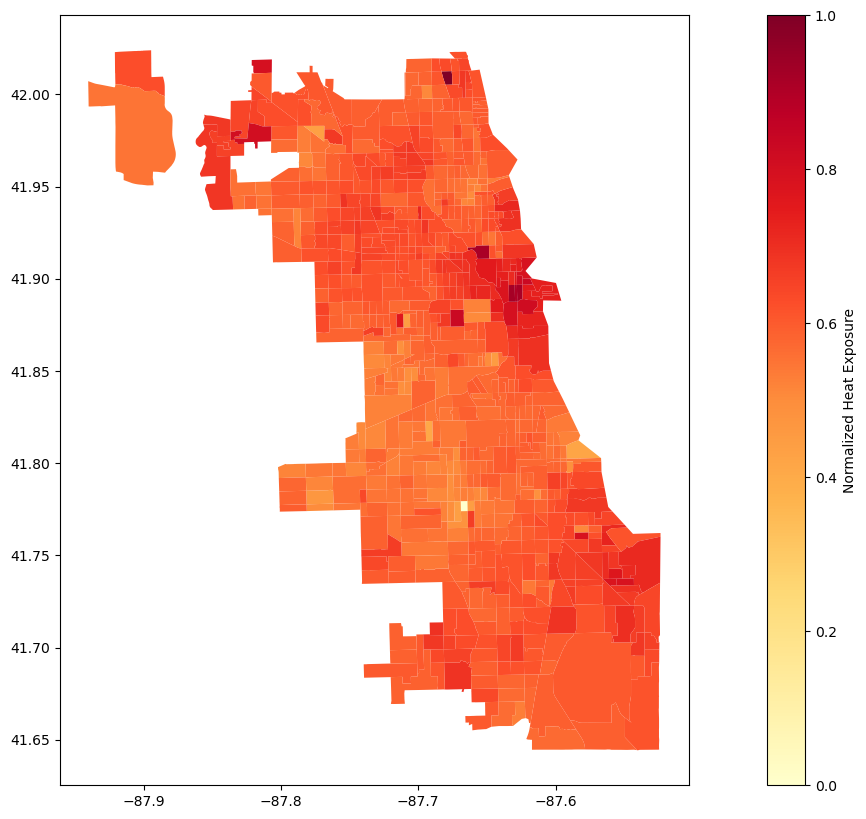

In [22]:
## Creating Choropleth Map with geopandas 
chicago.plot(column = 'he_val', #Assign numerical data column
                      legend = True, #Decide to show legend or not
                      figsize = [20,10],
                      cmap = 'YlOrRd',
                      legend_kwds = {'label': "Normalized Heat Exposure"}) #Name the legend

<a id='1km'></a>

## 3.2. 1km Spatial Resolution

The following cell conduct a analysis of human sentiments of urban heat at 1km spatial resolution in the city of Chicago.

In [33]:
## Generate raster based about 1 km spatial resoltuion 
## one Degree latitude = 111 km
## In chicago, where latitude = 41.881832, one Degree longitude = 82 km
## We use this estimation for the following ananlsis
## This work as the city of Chicago is small
lat_start = 41.05
lon_start = -87.96

incre_lat = 1/111
incre_lon = 1/82

lat_end = 42.05
lon_end = -87.5

raster = []

lat = lat_start

while(lat<lat_end):
    lon = lon_start
    while(lon<lon_end):
        curr_point = Point(lon, lat)
        if (curr_point.within(chicago_shape)):
            raster.append([lon, lat])
        lon = lon+incre_lon
    lat = lat+incre_lat

Generate reuslt for the human sentiments of heat exposure at different timeframe at fine temporal granularity.

In [34]:
## Generate a random point from a polygon
import random

def generate_random(number, polygon):
    minx, miny, maxx, maxy = polygon.bounds
    pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    return pnt

In [35]:
## Function to generate random location twitter
## For monte caro experiment
## Enable exact and poly if you want to see how many twitter has exact location and how many comes with a polygon
#exact = 0
#poly = 0
def generate_random_loc(weather_related_twitter):
    random_loc_twitter = []
    for ele in weather_related_twitter:
        loc = ele[0]
        point = 0
        #print(loc)
        if (type(loc)==Point):
            ## exact location extracted
            point = loc
            #exact = exact+1
        else:
            ## Select a random point from a multi-polygon
            point = generate_random(1, Polygon(loc))
            #poly = poly+1
        random_loc_twitter.append([point, ele[2]])
    return random_loc_twitter

Calcualte the human sentiments of heat exposure. Using Inverse Distance Weighting (IDW) for those spatial unit that doesn't have a points. And using Monte-Carlo simulation to take care of those multi-polygon locations in the social media posts.

In [36]:
## Set seed for reproducibility
## This may take a while

d_final = {}

for i in range(0, 10):
    ## try 100 random time
    print("current "+str(i))

    ## Conduct kernel density estimation
    random_loc_twitter = generate_random_loc(weather_related_twitter)

    ### fill with inverse distance weighting


    for ele in raster:
        lon = ele[0]
        lat = ele[1]
        ## iterate through all the values in the existing twitter
        up = 0
        down = 0
        IDW = 0
        for twitter in random_loc_twitter:
            pt = twitter[0]
            curr_x = pt.x
            curr_y = pt.y
            curr_val = twitter[1]

            distx = (curr_x-lon)*82
            disty = (curr_y-lat)*111

            w = 1/np.sqrt(distx*distx+disty*disty)

            down = down+w
            up = up+w*curr_val
        rt = up/down
        
        key = (ele[0],ele[1])
        if (key not in d_final.keys()):
            d_final[key]=[rt]
        else:
            d_final[key].append(rt)

current 0
current 1
current 2
current 3
current 4
current 5
current 6
current 7
current 8
current 9


In [37]:
heat_exposure_map = {}
for key in d_final.keys():
    ## Get the average hot exposure
    heat_exposure_map[key] = np.mean(d_final[key])

In [38]:
## nomalization to 0-1
mn = min(heat_exposure_map.values())
mx = max(heat_exposure_map.values())
for key in heat_exposure_map.keys():
    norm = (heat_exposure_map[key]-mn)/(mx-mn)
    heat_exposure_map[key] = norm

In [39]:
lonl = []
latl = []
var = []

final_heat_exposure_map = {}
for key in heat_exposure_map.keys():
    
    lonl.append(key[0])
    latl.append(key[1])
    var.append(heat_exposure_map[key])

In [40]:
df = pd.DataFrame(np.column_stack([lonl, latl, var]), 
                  columns=['lon', 'lat', 'val'])

In [41]:
df

,lon,lat,val
0,-87.545366,41.644595,0.328998
1,-87.533171,41.644595,0.328606
2,-87.618537,41.653604,0.409068
3,-87.606341,41.653604,0.386764
4,-87.594146,41.653604,0.442598
...,...,...,...
588,-87.777073,42.013964,0.263709
589,-87.703902,42.013964,0.311188
590,-87.691707,42.013964,0.313629
591,-87.679512,42.013964,0.336289


array([<Axes: xlabel='lon', ylabel='lat'>], dtype=object)

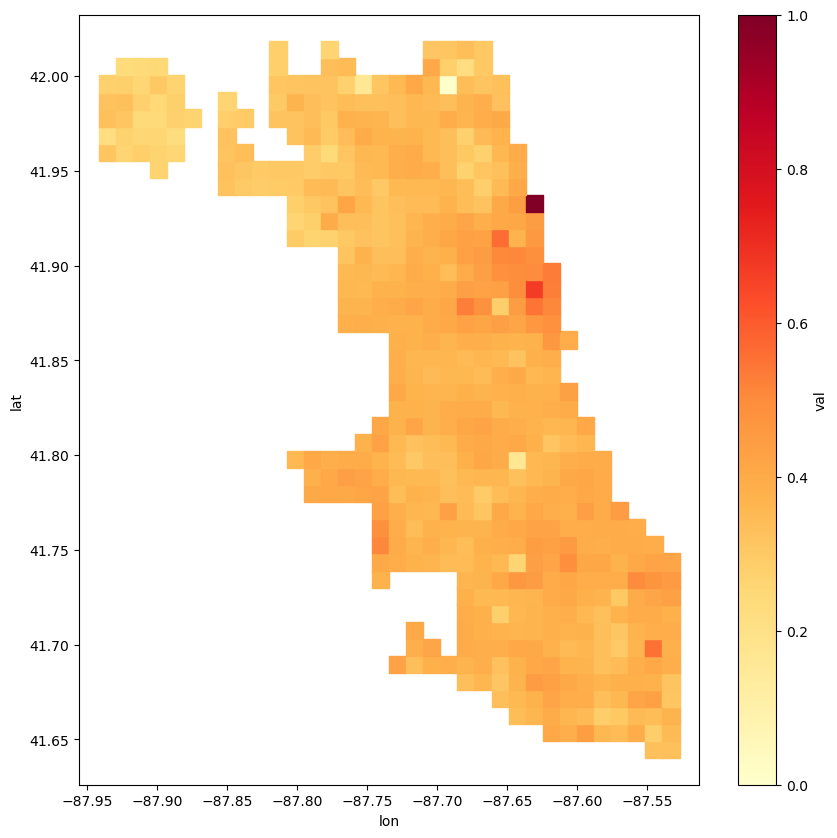

In [44]:
df.plot.scatter(x='lon', y='lat', c='val', figsize = [10,10], subplots=True, marker="s", s = 155, cmap = 'YlOrRd')